# **Analyzing NSW Public Transports Usage - Opal Cards' Tap-ons and Tap-offs**

## Problem Tasks: 

- Assess if **demographic data** (age group) has _direct and significant impacts_ on **public transport usage**. 

The dataset includes the _**total number of specified transportations to work by age** in ten-year groups_ in New South Wales taken from [the TableBuilder of the Australian Bureau of Statistics (ABS)](https://guest.censusdata.abs.gov.au/webapi/jsf/login.xhtml). 

**The census of Australian** was conducted in 2016, and the dataset was created and filtered from the census surveys of persons in usual residence areas across New South Wales, Australia. 

**Process:**
- Data preparation: 
    - Clean the dataset (transpose column to row, remove logo, title of organisation, etc.). 
    
    - Group the records into two major groups: under 60 (youth + workforce) years as class 0, over 60 (retiree) years as class 1.

- Data exploration: Plot graphs to compare transport usage of each broader age group to point out any direct relationshop between 2 factors.

- Model training: Logistic Regression, KNN, GaussianNB, and MLPClassifier.

**Goal:**

To study if _a specific age group_ could predict **any of the predefined transport modes**, or whether _the working force choose train_ as the most convenient method of transport.

## Import Libraries

In [83]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

# Plot
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Functions used for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Functions used for K-Nearest Neighbours Classifier
from sklearn.neighbors import KNeighborsClassifier

# Functions used for Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Functions used for Neural Network
from sklearn.neural_network import MLPClassifier

# Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## Data Preparation

### Import Data and Remove Texts 

As the dataset was taken **from the TableBuilder of the ABS**, we have to add modifications and convert it into an "_analysable_" format in the Notebook environment.

In [84]:
# Import data, skip the rows of logo and titles/names of the organisations
df = pd.read_excel("data/transportmodevsAge.xlsx", skiprows= 8, index_col =0, engine="openpyxl")

# Set the first row as column names
df.columns = df.iloc[0]

# Remove the first two rows after setting it as column names (second row of NaN values and an header description)
df = df.iloc[2:]

# Remove several last rows of copyright, logo and sources
df = df[:5]

# Transpose columns and rows
df = df.T

# Remove several last rows of NaN values
age_total = df[12:13] # the index "Total"
df_age = df[:12] # not include index "Total"

# Rename columns
age_total.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]
df_age.columns = ["Train", "Bus", "Ferry", "Tram", "Total"]

# Remove first row (transport title and NaN value)
df_age = df_age.iloc[1:]

# Final dataframe
df_age


,Train,Bus,Ferry,Tram,Total
AGE10P - Age in Ten Year Groups,,,,,
0-9 years,0,0,0,0,0
10-19 years,10869,8421,69,74,19431
20-29 years,115402,41592,1702,914,159610
30-39 years,114937,40941,3094,1077,160044
40-49 years,69864,28815,2617,722,102016
50-59 years,48007,19717,1522,452,69695
60-69 years,17732,7824,543,159,26257
70-79 years,1781,973,88,13,2855
80-89 years,166,92,4,0,265


### Removing Outliers

The statistics of the _0-9 and 100 years and over_ range are 0; therefore, we consider them as **outliers** and remove them from the dataframe. 

In [85]:
# Exclude outliers 
df_age = df_age[1:10]

### Replace the Total Column

Since there are several incorrect values in the "Total" field, we will re-calculate this field.

In [86]:
# Drop the Total column 
df_age.drop(["Total"], axis=1, inplace=True)

# Create new Total column
df_age["Total"] = df_age.Train + df_age.Bus + df_age.Ferry + df_age.Tram

# Preview new dataframe
df_age

,Train,Bus,Ferry,Tram,Total
AGE10P - Age in Ten Year Groups,,,,,
10-19 years,10869,8421,69,74,19433
20-29 years,115402,41592,1702,914,159610
30-39 years,114937,40941,3094,1077,160049
40-49 years,69864,28815,2617,722,102018
50-59 years,48007,19717,1522,452,69698
60-69 years,17732,7824,543,159,26258
70-79 years,1781,973,88,13,2855
80-89 years,166,92,4,0,262
90-99 years,20,13,0,0,33


### Group Age Ranges into Class

We divide all **11 age ranges** into _two classes of 0 and 1_:
- class 0: the youth and working force 

- class 1: the retiree group.

In [87]:
# Define function to classify age groups
def classify_age_group(age_group):
    youth_working_force = ["10-19 years", "20-29 years", "30-39 years", "40-49 years", "50-59 years"]
    return 0 if age_group in youth_working_force else 1

# Apply function to create Class column dynamically
df_age["Class"] = df_age.index.map(classify_age_group)

# Preview new dataframe
df_age

,Train,Bus,Ferry,Tram,Total,Class
AGE10P - Age in Ten Year Groups,,,,,,
10-19 years,10869,8421,69,74,19433,0
20-29 years,115402,41592,1702,914,159610,0
30-39 years,114937,40941,3094,1077,160049,0
40-49 years,69864,28815,2617,722,102018,0
50-59 years,48007,19717,1522,452,69698,0
60-69 years,17732,7824,543,159,26258,1
70-79 years,1781,973,88,13,2855,1
80-89 years,166,92,4,0,262,1
90-99 years,20,13,0,0,33,1


### Data Summary

In [88]:
# Dataframe dimension
df_age.shape

(9, 6)

In [89]:
# Group by Class and sum transport mode columns
summary = df_age.groupby("Class")[["Train", "Bus", "Ferry", "Tram", "Total"]].sum()

# Display the summary
print(summary)  

        Train     Bus Ferry  Tram   Total
Class                                    
0      359079  139486  9004  3239  510808
1       19699    8902   635   172   29408


**Observations:**

1. **Youth & Working Force (Class 0)** _Dominates_ Usage
    - They make up the vast majority of transport users across all modes.

    - Train usage is particularly high for this group (359,079), making it the most preferred transport option.

2. **Retirees (Class 1)** Have _Significantly Lower Usage_
    - Their total transport usage (29,408) is much lower than Class 0 (510,888).

    - Bus usage (8,902) is slightly higher than Ferry (635) and Tram (172), suggesting retirees may rely on buses more.

3. **Train** is the _Most Used Transport Mode_ for Both Groups
    - Even among retirees, the train (19,699) is used more than other modes.

## Data Exploration

Firstly, we plot a histogram of transport uses by each mode.

Text(0.5, 1.0, 'Total Usage by Transport Modes')

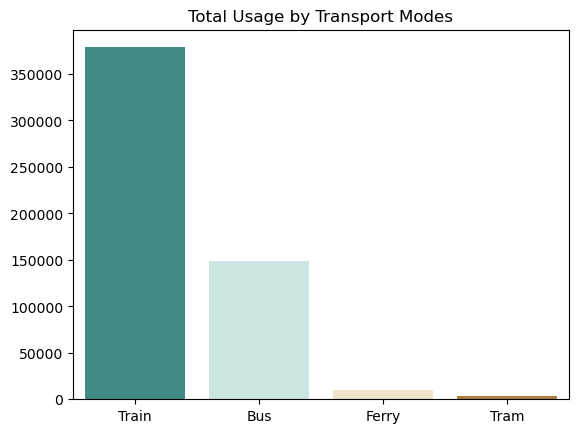

In [90]:
# Retrieve data for all transport modes and create plot
trans_modes_total = age_total.drop(["Total"], axis=1)
sns.barplot(data= trans_modes_total, palette= "BrBG_r").set_title("Total Usage by Transport Modes")

* ***Interpretation:*** Train service stands out as the transport mode with the highest passengers across all age groups (378778 taps in total).

And another plot to find out how each age group _uses all the transport modes_:

In [91]:
# Retrive data for all transport modes by age groups
trans_modes_by_agegr = df_age.drop(["Class", "Total"], axis=1)
trans_modes_by_agegr["Age Groups"] = trans_modes_by_agegr.index
trans_modes_by_agegr

,Train,Bus,Ferry,Tram,Age Groups
AGE10P - Age in Ten Year Groups,,,,,
10-19 years,10869,8421,69,74,10-19 years
20-29 years,115402,41592,1702,914,20-29 years
30-39 years,114937,40941,3094,1077,30-39 years
40-49 years,69864,28815,2617,722,40-49 years
50-59 years,48007,19717,1522,452,50-59 years
60-69 years,17732,7824,543,159,60-69 years
70-79 years,1781,973,88,13,70-79 years
80-89 years,166,92,4,0,80-89 years
90-99 years,20,13,0,0,90-99 years


In [92]:
# Unpivot the data by transport types
trans_modes_by_agegr_melted = pd.melt(trans_modes_by_agegr, id_vars = "Age Groups", var_name="Transport Types")
trans_modes_by_agegr_melted.head(9)

,Age Groups,Transport Types,value
0,10-19 years,Train,10869
1,20-29 years,Train,115402
2,30-39 years,Train,114937
3,40-49 years,Train,69864
4,50-59 years,Train,48007
5,60-69 years,Train,17732
6,70-79 years,Train,1781
7,80-89 years,Train,166
8,90-99 years,Train,20


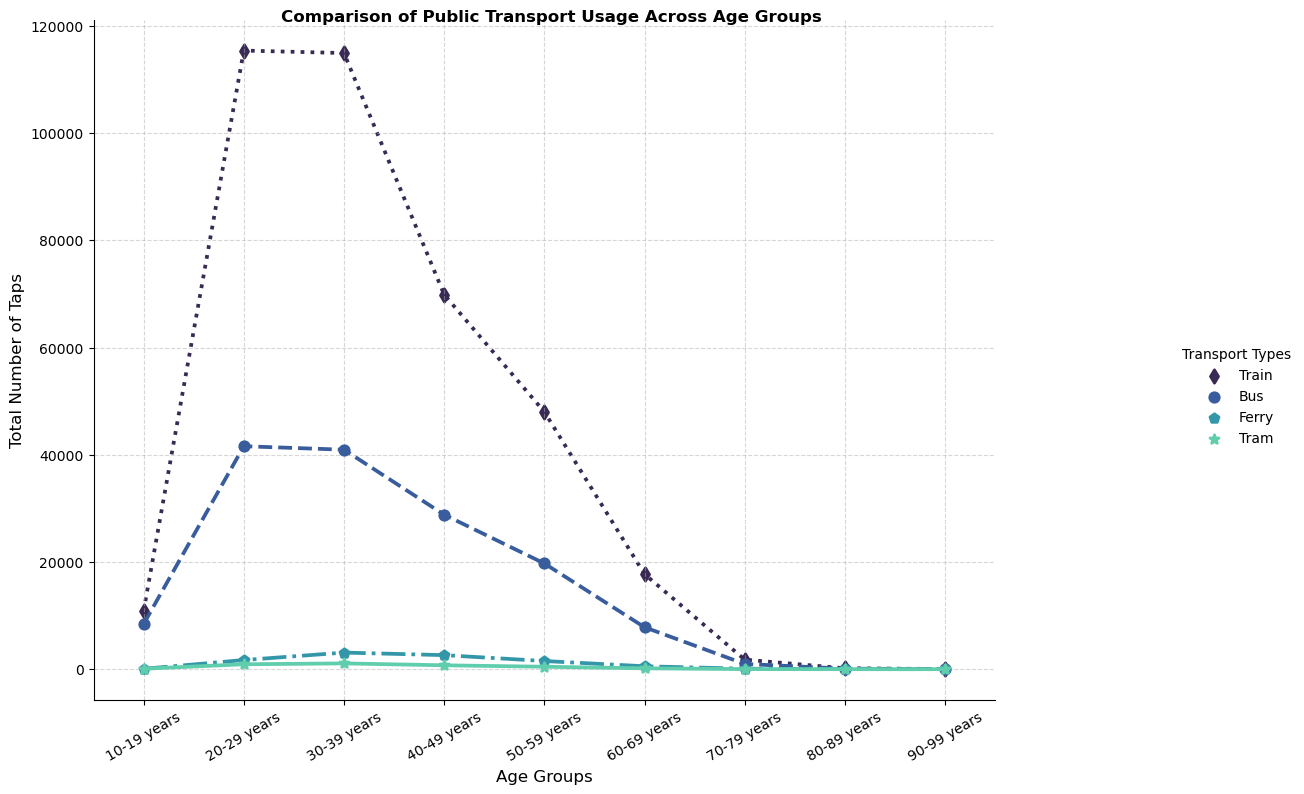

In [93]:
# Create the plot
trans_modes_by_agegr_plot = sns.catplot(
    x="Age Groups", y="value",
    markers=["d", "o", "p", "*"], 
    linestyles=["dotted", "dashed", "dashdot", "solid"],
    kind="point", hue="Transport Types",
    data=trans_modes_by_agegr_melted, palette="mako"
)

# Adjust figure size
trans_modes_by_agegr_plot.fig.set_size_inches(15,8)

# Set title with better font size
trans_modes_by_agegr_plot.fig.suptitle(
    "Comparison of Public Transport Usage Across Age Groups", 
    fontsize=12, fontweight="bold"
)

# Set axis labels
plt.xlabel("Age Groups", fontsize=12)
plt.ylabel("Total Number of Taps", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=30)

# Adjust legend position for better visibility
# plt.legend(title="Transport Types", loc="upper right", fontsize=10)

# Add gridlines for readability
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()

**Key Insights:** 
   1. **Train and Bus are the most used transport modes**, peaking in the **20-29 age group** and declining sharply after 50 years.

   2. **Ferry and Tram usage remain low** across all age groups, suggesting _limited accessibility or demand_.

   3. **Public transport usage drops significantly after 50 years**, likely due to _alternative transport options or reduced mobility_.

   4. **Young adults (20s-30s) rely most on public transport**, possibly for commuting, while older groups use it less.

Analyzing the usage of each transport mode by each age range in percentage will provide a proper assessment on **how all transport modes are distributed**.

In [94]:
# Transform the data to percentage
transport_modes = ["Train", "Bus", "Ferry", "Tram"]
df_age[transport_modes] = df_age[transport_modes].div(df_age["Total"], axis=0) * 100
df_age.fillna(0, inplace=True)  # Replace NaN values if any division by zero occurred
# View the updated dataframe
df_age

,Train,Bus,Ferry,Tram,Total,Class
AGE10P - Age in Ten Year Groups,,,,,,
10-19 years,55.930633,43.333505,0.355066,0.380796,19433,0
20-29 years,72.302487,26.058518,1.066349,0.572646,159610,0
30-39 years,71.813632,25.580291,1.933158,0.672919,160049,0
40-49 years,68.482033,28.245016,2.565234,0.707718,102018,0
50-59 years,68.87859,28.289191,2.183707,0.648512,69698,0
60-69 years,67.529896,29.796633,2.067941,0.60553,26258,1
70-79 years,62.381786,34.08056,3.082312,0.455342,2855,1
80-89 years,63.358779,35.114504,1.526718,0.0,262,1
90-99 years,60.606061,39.393939,0.0,0.0,33,1


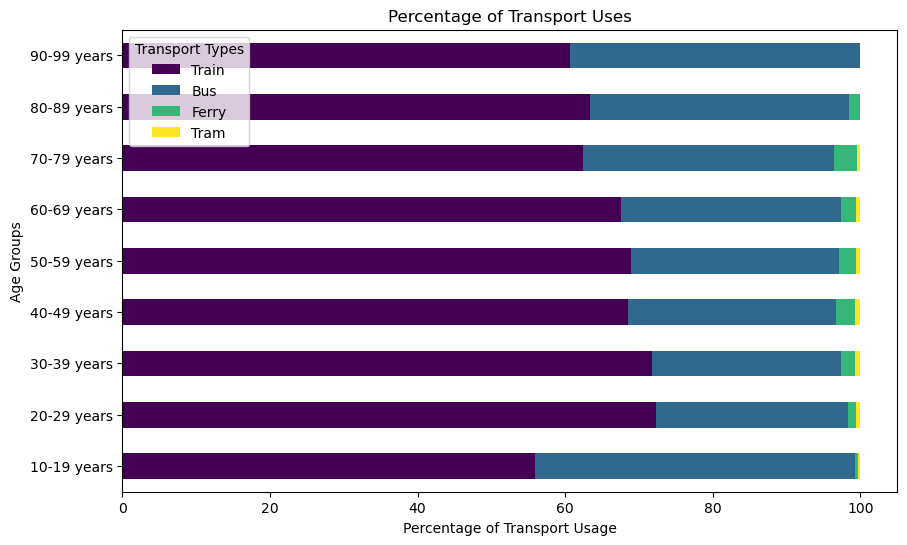

In [95]:
# Plot how all transport modes are distributed in each age range
trans_modes_by_agegr_perc = df_age[["Train", "Bus", "Ferry", "Tram"]].copy()
trans_modes_by_agegr_perc["Age Groups"] = df_age.index

trans_modes_by_agegr_perc_plot = trans_modes_by_agegr_perc.plot(
    x="Age Groups", kind="barh", stacked=True, 
    title="Percentage of Transport Uses", colormap="viridis", figsize=(10, 6)
)
trans_modes_by_agegr_perc_plot.set_xlabel("Percentage of Transport Usage")
trans_modes_by_agegr_perc_plot.set_ylabel("Age Groups")
trans_modes_by_agegr_perc_plot.legend(title="Transport Types")

**Key Insights:**
1. **Train is dominant for young adults (20-39 years) (_~70%_)**, but usage declines with age.

2. **Bus usage increases with age**, becoming the primary mode for seniors (60+ years).

3. **Ferry & Tram have minimal usage**, slightly higher in older groups.

Lastly, we examine how **the number of travellings of each age class varies**. (Note: _we have defined two classes_).

<AxesSubplot: xlabel='Class', ylabel='Total'>

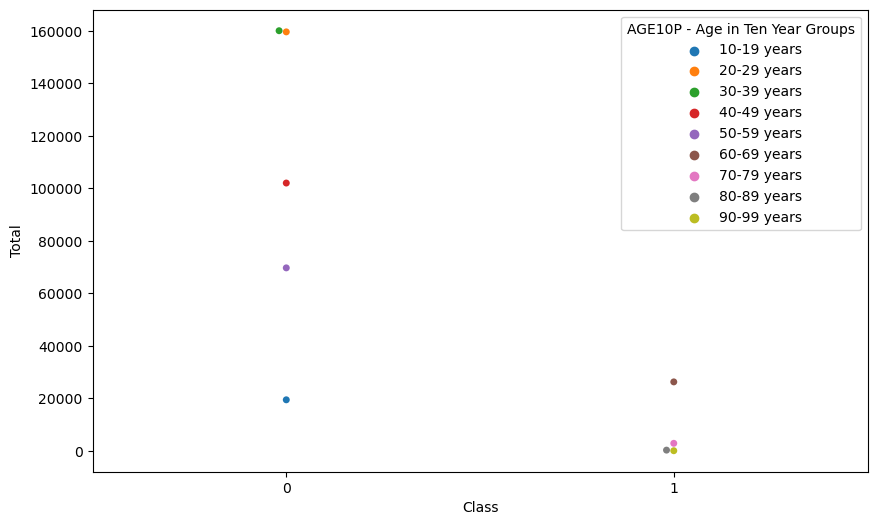

In [96]:
# Plot transport usage by each age class
plt.figure(figsize=(10,6))
sns.swarmplot(x='Class', y='Total', data= df_age, hue= df_age.index)

**Key Insights:** 
- **Class 0 (Younger & Middle-aged adults)**: Ages **10-59 years**, showing significantly higher transport usage. The peak is in the **20-39 age range**, suggesting _working-age individuals rely heavily on public transport_.
- **Class 1 (Older adults & Seniors)**: Ages **60-99 years**, with a sharp decline in transport usage. The lowest values are in the **80+ age groups**, reflecting _reduced mobility or alternative transport choices_.

## Model Training 

**Overview**: 

We use all `travelling statistics` as _independent variables_ to predict `class` as the _target variable_.

`Logistic Regression`, `K-Nearest Neighbours Classifier`, `Gaussian Naive Bayes`, `Multi-layer Perception` will be applied and assessed to retrieve the most optimal model.

### Splitting Data

In [97]:
# Split data into training and testing sets (50% each)
train, test = train_test_split(df_age, test_size=0.5, random_state=7)

# Separate features and target
X_train, X_test = train.drop(columns=['Total', 'Class']), test.drop(columns=['Total', 'Class'])
y_train, y_test = train['Class'], test['Class']

# Print shapes for verification
print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shape: (4, 6), Test shape: (5, 6)
X_train: (4, 4), y_train: (4,)
X_test: (5, 4), y_test: (5,)


### Logistic Regression

**Fitting the model:**

In [98]:
# Create model instance and fit the training data 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [99]:
# Produce predictions with LR model 
y_train_pred = lr.predict(X_train)
y_test_pred= lr.predict(X_test)

In [100]:
# Evaluate LR model
print(f"Accuracy Score on training test: {accuracy_score(y_train,y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test,y_test_pred)}")

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.6


The model has a **perfect accuracy (1.0)** _on the training set_ but a **lower accuracy (0.6)** _on the testing set_, which suggests **overfitting**.

In [101]:
# define the model evaluation procedure
lr_cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=7)

We define a list of accuracy scores of all models so that a proper comparison can be assessed in the end.

In [102]:
# List of accuracy scores on test set
test_scores = []
test_scores.append(accuracy_score(y_test, y_test_pred))

In [103]:
# Checking confusion matrix on test set 
print("Confusion Matrix on test set:")
print(confusion_matrix(y_test, y_test_pred))    

Confusion Matrix on test set:
[[1 1]
 [1 2]]


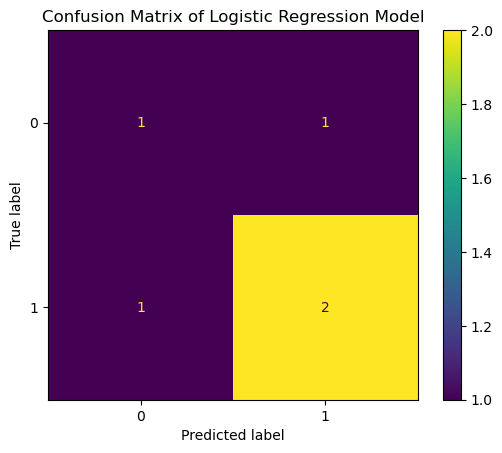

In [104]:
# Display confusion matrix of Logistic Regression model
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)
plt.title("Confusion Matrix of Logistic Regression Model")
plt.show()

Observations based on the Confusion Matrix:

- **Accuracy is 60%**, which is not significant enough.
- **Balanced errors**: The model makes both _false positives_ and _false negatives_.
- **Small dataset issue?** This matrix suggests _very few test samples_. 

Now we set up a loop to assess the accuracy scores by the LR model with different number of features:

In [105]:
# Define list to store accuracy scores
acc_scores = []

for i in range(1,5):
    # Create LR model instance
    lr = LogisticRegression(max_iter=1000)

    # Create RFE model instance
    rfe = RFE(estimator=lr, n_features_to_select=i)

    # Fit the RFECV model
    rfe.fit(X_train, y_train)

    # Produce predictions with RFECV model
    y_pred = rfe.predict(X_test)

    # Evaluate RFECV model
    acc_score = accuracy_score(y_test, y_pred)

    # Print the accuracy score with the number of features
    print(f"Acc on test set using {i} feature: {acc_score}")
    print(f"Feature which have been chosen: {X_train.columns[rfe.support_]}")
    print("")

    # Append to the list 
    acc_scores.append(acc_score)

Acc on test set using 1 feature: 0.6
Feature which have been chosen: Index(['Train'], dtype='object')

Acc on test set using 2 feature: 0.6
Feature which have been chosen: Index(['Train', 'Bus'], dtype='object')

Acc on test set using 3 feature: 0.6
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry'], dtype='object')

Acc on test set using 4 feature: 0.6
Feature which have been chosen: Index(['Train', 'Bus', 'Ferry', 'Tram'], dtype='object')



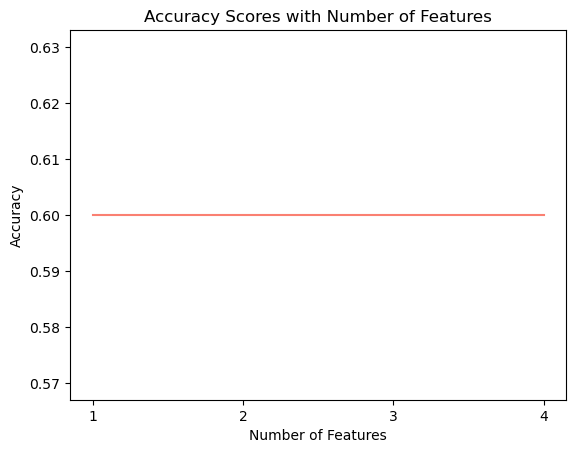

In [106]:
# Plot the accuracy scores with the number of features
lr_acc_plot = plt.plot(range(1, X_train.shape[1]+1), acc_scores, color= "salmon")
plt.title("Accuracy Scores with Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, 5, step=1))
plt.show()

RFE suggests that the _accuracy remains the same for the selection of features_. Therefore, all 4 features can be used to conduct the model and prevent the overfitting problem.

**Cross-Validation Testing:**

In [107]:
# Retrieve data for the cross-validation test on LR model
X = df_age.drop(["Total", "Class"], axis= 1)
y = df_age["Class"]

In [108]:
# Create LR model instance
lr = LogisticRegression(max_iter=1000)

# Generate cross-validation scores
lr_cv_score = cross_val_score(lr, X, y, scoring='accuracy', cv=3)

# Print the accuracy range, mean and standard deviation
print('Accuracy range for Logistic Regression: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (lr_cv_score.min(), lr_cv_score.max(), lr_cv_score.mean(), lr_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(lr_cv_score.mean())

Accuracy range for Logistic Regression: [0.3333, 1.0000]; mean: 0.5556; std: 0.3143



The model shows **high variance** and **low generalization**:

- **Accuracy varies widely** (_33.33% to 100%_), suggesting **instability**.
- **Mean accuracy** (_55.56%_) is **low**, indicating **weak predictive power**.
- **High standard deviation** (_31.43%_) shows **inconsistent performance** across folds.

### K-Nearest Neighbours Classifier

**Fitting the model:**

In [109]:
# Create a K-Nearest Neighbours Classifier model instance and fit the training data
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [110]:
# Produce predictions with KNN model
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [111]:
# Evaluate KNN model
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

# Append the accuracy score to the list
test_scores.append(accuracy_score(y_test, y_test_pred))

Accuracy Score on training test: 0.75
Accuracy Score on testing test: 0.4


The **KNN model** is **_underperforming_**:

- **Training Accuracy: 75%** → Model fits reasonably well.
- **Testing Accuracy: 40%** → Model struggles on unseen data (**overfitting**).

We can not increase the `n_neighbors` to reduce variance due to limited number of training features.

**Cross-Validation Testing:**

In [112]:
# Create a K-Nearest Neighbours Classifier model instance
knn = KNeighborsClassifier(n_neighbors=3)

# Generate cross-validation scores for KNN model with cross-validation
knn_cv_score = cross_val_score(knn, X, y, scoring='accuracy', cv=2)

# Print the accuracy range, mean and standard deviation
print('Accuracy range for K-Nearest Neighbours: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (knn_cv_score.min(), knn_cv_score.max(), knn_cv_score.mean(), knn_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(knn_cv_score.mean())

Accuracy range for K-Nearest Neighbours: [0.6000, 1.0000]; mean: 0.8000; std: 0.2000



The model shows **better performance** and **inconsistency**:

- **Accuracy Range**: `[0.6000, 1.0000]` → Model _performance varies across folds_.
- **Mean Accuracy**: `0.8000` → _Decent overall performance_.
- **Standard Deviation**: `0.2000` → _High variability_, indicating **inconsistency** across data splits.

### Gaussian Naive Bayes

**Fitting the model**

In [113]:
# Create a Gaussian Naive Bayes model instance and fit the training data
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [114]:
# Produce predictions with GNB model
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

In [115]:
# Evaluate GNB model
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

# Append the accuracy score to the list
test_scores.append(accuracy_score(y_test, y_test_pred))

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.4


The possibility of **overfitting** is still high as the model performs _well on training data_ but _poorly on test data_.

**Cross-Validation Testing:**

In [116]:
# Create a Gaussian Naive Bayes model instance
gnb = GaussianNB()

# Generate cross-validation scores for GNB model with cross-validation
gnb_cv_score = cross_val_score(gnb, X, y, scoring='accuracy', cv=5)

# Print the accuracy range, mean and standard deviation for GNB model   
print('Accuracy range for Gaussian Naive Bayes: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (gnb_cv_score.min(), gnb_cv_score.max(), gnb_cv_score.mean(), gnb_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(gnb_cv_score.mean())

Accuracy range for Gaussian Naive Bayes: [0.0000, 1.0000]; mean: 0.7000; std: 0.4000



The model shows extreme **inconsistency**:

- **High Variance** (_STD=0.4_): Performance fluctuates a lot across different folds.
- **Extreme Accuracy Scores** (_0.0 to 1.0_): Some folds classify perfectly, others completely fail.


### Multi-layer Perceptron

**Fitting the model:**

In [117]:
# Create a Multi-layer Perception model instance and fit the training data
mlp = MLPClassifier(max_iter=800, solver="lbfgs", activation="tanh", random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(activation='tanh', max_iter=800, random_state=42, solver='lbfgs')

In [118]:
# Produce predictions with MLP model
y_train_pred = mlp.predict(X_train)
y_test_pred = mlp.predict(X_test)

In [119]:
# Evaluate MLP model 
print(f"Accuracy Score on training test: {accuracy_score(y_train, y_train_pred)}")
print(f"Accuracy Score on testing test: {accuracy_score(y_test, y_test_pred)}")

# Append the accuracy score to the list
test_scores.append(accuracy_score(y_test, y_test_pred))

Accuracy Score on training test: 1.0
Accuracy Score on testing test: 0.6


The possibility of **overfitting** still exists when testing accuracy (_60%_) is moderate, but there's a big gap from training accuracy (_100%_).

**Cross-Validation Testing:** 

In [120]:
# Create a Multi-layer Perception model instance
mlp =  MLPClassifier(max_iter=800, solver="lbfgs", activation="tanh", random_state=42)

# Generate cross-validation scores for MLP model with cross-validation
mlp_cv_score = cross_val_score(mlp, X, y, scoring='accuracy', cv=4)

# Print the accuracy range, mean and standard deviation for MLP model
print('Accuracy range for MLP: [%.4f, %.4f]; mean: %.4f; std: %.4f\n' % (mlp_cv_score.min(), mlp_cv_score.max(), mlp_cv_score.mean(), mlp_cv_score.std()))

# Append the mean accuracy score to the list
test_scores.append(mlp_cv_score.mean())

Accuracy range for MLP: [0.3333, 1.0000]; mean: 0.7083; std: 0.2976



The model shows **high variance** issues due to: 

- The **large standard deviation** (_0.2976_) indicates that model performance _varies significantly across folds_.
- **Accuracy** fluctuates from _33.33%_ (very poor) to _100%_ (perfect), suggesting **instability**.

### Model Comparison

In [122]:
# Create a dataframe to store the accuracy scores
models = ["LR_Split", "LR_CV", "KNN_Split", "KNN_CV", "GNB_Split", "GNB_CV", "MLP_Split", "MLP_CV"]
df_acc_score = pd.DataFrame(models, columns=["Model Type"])
df_acc_score["Accuracy"] = test_scores

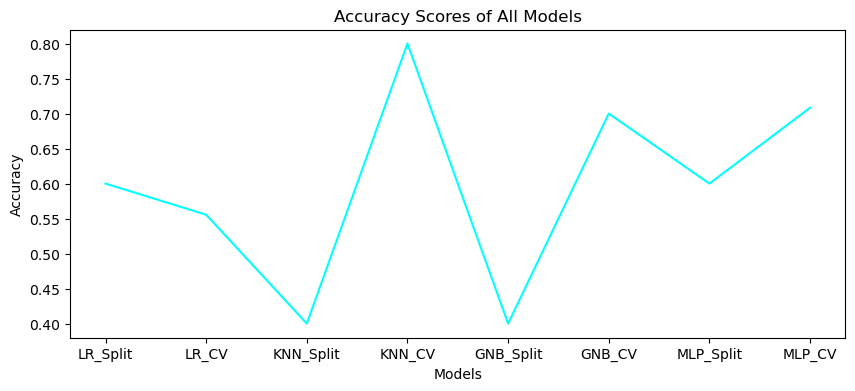

In [124]:
# Plot the accuracy scores of all models 
plt.figure(figsize = (10,4))
plt.plot(df_acc_score["Model Type"], df_acc_score["Accuracy"], color= "aqua")
plt.title("Accuracy Scores of All Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

The plot shows **accuracy scores** for different models using both **_train-test split (Split)_** and **_cross-validation (CV)_** approaches:

1. `KNN_CV` Achieves the **Best Accuracy** (_~0.80_):
    - KNN with cross-validation performs significantly better than other models.
    - Suggests that tuning hyperparameters with CV improves generalization.

2. `GNB_CV` & `MLP_CV` Show **Moderate Performance** (_~0.65-0.70_):
    - Gaussian Naïve Bayes (GNB) and Multi-layer Perceptron (MLP) with cross-validation show improvement over their split-based counterparts.

3. **Inconsistent Performance** of `KNN_Split` & `GNB_Split`:
    - KNN_Split has the worst accuracy (~0.40), highlighting that it struggles without cross-validation.
    - GNB_Split also has lower performance, suggesting instability.

4. Logistic Regression (`LR_Split` & `LR_CV`) Shows **Mid-Range Accuracy** (_~0.55-0.60_):
    - Logistic Regression performs reasonably well but doesn't outperform KNN_CV or MLP_CV.

→ The **most optimal model**: **KNN_CV** (_K-Nearest Neighbors with Cross-Validation_)

## Conclusion

The `transport usage by age group` dataset was handled carefully before data exploration and model training tasks: 
- Remove logos and titles. 
- Remove outliers due to 2 groups with zero-records.
- Recalculate the total field to minimise the incorrect data. 

The most _noticeable observation_ on this dataset is the **small dimensionality**, thus it directly leads to the **overfitting** issue.

A combination of **4 models** have been trained on the dataset and they show different key insights. Despite _various disadvantages due to small dataset size_, **K-Nearest Neighbors with Cross-Validation** is recognized as the most optimal with the highest accuracy score.